#To understand how to use functional APIS, and implement ENA's network

![alt text](https://2.bp.blogspot.com/-HQo2Kx39Q6A/WsqZQn5pJHI/AAAAAAAAVhY/FBkgOeS06vQNvZN2KI2hhGZmfS1cNPg8wCLcBGAs/s1600/enasdiscoverednetwork.png)

**Instructions**

1) The lines you see are the skip-connections. You need to add them.

2) Train for 100 Epochs (add BN and ReLU after every layer)

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import required libraries, Load and prepare data to train model, defining functions for accurcay, plot model.

In [0]:
#Import libraries

from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout,GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

##As mentioned we have to use CIFAR10 dataset.

1.   Image size- 32x32
2.   Train dataset- 50k images
3.   Test dataset- 10k images
4.   Num_classes=10






In [55]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))
print(train_features.shape)
print(test_features.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


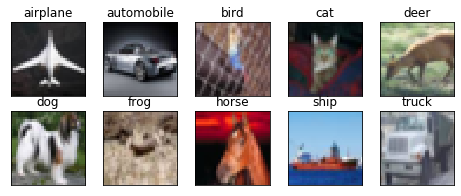

In [56]:
#plot some train examples
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
#function to plot graph of training
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
#Accuracy function 
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
#Normalize data
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

##Lets design the given model

As we can see from the given network it has soo many skip connections. So It will be good to define function for implementing skip connection, and convolution operation. 



1).   **add_skip_conn(layers=[])** - https://keras.io/layers/merge/

  added = keras.layers.Add()([x1, x2])- we need to pass list of layers that need to be added to keras ADD() function. 


2).   **Lambda** : This is a keras layer that wraps any given function as a layer of the network architecture.


3).  **reshape()**- This method uses the tensorflow utility tf.nn.space_to depth() in order to move the spatial dimension of the image to the depth dimension. This is required to have skip connections b.w layers with different channel sizes. Reference- https://www.tensorflow.org/api_docs/python/tf/nn/space_to_depth

https://stackoverflow.com/questions/44264962/how-tf-space-to-depth-works-in-tensorflow

4).  **build_convolution()**- It implements convolution layers with 2 cases one  for normal convolution and other for separable convolution.





In [0]:
from keras.layers import Activation, Flatten, Dense, Dropout, GlobalAveragePooling2D, Input, Conv2D, MaxPooling2D, Concatenate, Add, Reshape, Lambda
import tensorflow as tf




Functions for implementing skip connections and convolution layers

In [0]:
def add_skip_conn(layers = []):
  return Activation('relu')(Add()(layers))

def reshape(x, block_size):
    return tf.nn.space_to_depth(x, block_size)

def build_convolution(x, is_separable = False, kernel_size = 3, num_filters = 16, isBatchNorm = True):
  if is_separable:
    x1 = Conv2D(num_filters, (kernel_size,1), padding = 'same', use_bias = False)(x)
    x2=Conv2D(num_filters, (1,kernel_size), padding = 'same', use_bias = False)(x1)
    x3= BatchNormalization()(x2)
    x4=Activation('relu')(x3)
    return x4
  
  else:
    x1=Conv2D(num_filters, (kernel_size,kernel_size), padding = 'same', use_bias = False)(x)
    x2=Activation('relu')(BatchNormalization()(x1))
    return x2

To build model as described in picture.

Total params: 943,416

Trainable params: 941,816

Non-trainable params: 1,600

Points to remeber is use of tf.nn.space_to_depth(x, block_size), and use of 1X1 convolution for matching dimensions.
____________________________________


In [62]:
#build model

input1=Input(shape=(32,32,3))

out1= build_convolution(input1,True,5,8,True)

out2=build_convolution(out1, False,5,8,True)

out3=build_convolution(out2,False,5,8,True)

skip_conn1=add_skip_conn([out1, out3])

out4=build_convolution(skip_conn1,True,5,8,True)

skip_conn2=add_skip_conn([out4,out1])

out5=MaxPooling2D()(skip_conn2)


out1_hat = Lambda(reshape,arguments = {'block_size' : 2})(out1)
out4_hat = Lambda(reshape,arguments = {'block_size' : 2})(out4)
out3_hat = Lambda(reshape,arguments = {'block_size' : 2})(out3)


out6=build_convolution(out5,True,3,32,True)

skip_conn3=add_skip_conn([out6,out4_hat,out1_hat])
out7=build_convolution(skip_conn3,False,5,32,True)

skip_conn4=add_skip_conn([out7,out6,out4_hat,out3_hat])
out8=build_convolution(skip_conn4,True,3,32,True)

skip_conn5=add_skip_conn([out8,out6,out1_hat,out4_hat,out7,out3_hat])
out9=build_convolution(skip_conn5,True,5,32,True)

skip_conn6=add_skip_conn([out9,out8,out1_hat,out4_hat,out6])
out10_=MaxPooling2D()(skip_conn6)

out10 = build_convolution(out10_, False, 1, 128, True)

out6_prime = Lambda(reshape,arguments = {'block_size' : 2})(out6)
out7_prime = Lambda(reshape,arguments = {'block_size' : 2})(out7)
out8_prime = Lambda(reshape,arguments = {'block_size' : 2})(out8)
out1_prime = Lambda(reshape,arguments = {'block_size' : 4})(out1)
out4_prime = Lambda(reshape,arguments = {'block_size' : 4})(out4)
out3_prime = Lambda(reshape,arguments = {'block_size' : 4})(out3)
out2_prime = Lambda(reshape,arguments = {'block_size' : 4})(out2)


skip_conn7=add_skip_conn([out10,out7_prime])
out11=build_convolution(skip_conn7,False,5,128,True)

skip_conn8=add_skip_conn([out11,out8_prime,out2_prime,out1_prime])
out12=build_convolution(skip_conn8,True,5,128)


skip_conn9=add_skip_conn([out12,out11,out3_prime,out2_prime,out6_prime])
out13=build_convolution(skip_conn9,False,3,128,True)

skip_conn10=add_skip_conn([out13,out12,out4_prime,out6_prime,out1_prime,out3_prime,out8_prime])
out14=build_convolution(skip_conn10,True,5,128,True)

skip_conn11=add_skip_conn([out14,out12,out4_prime,out8_prime])


#for 10 output classes
out15 = Conv2D(10,(1,1), padding = 'same', use_bias = False)(skip_conn11)
out16 = GlobalAveragePooling2D()(out15)
softmax = Activation('softmax')(out16)
import keras
model = keras.Model(inputs = input1, outputs = softmax)

print(model.summary())



Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 32, 32, 8)    120         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 32, 32, 8)    320         conv2d_43[0][0]                  
__________________________________________________________________________________________________
batch_normalization_27 (BatchNo (None, 32, 32, 8)    32          conv2d_44[0][0]                  
____________________________________________________________________________________________

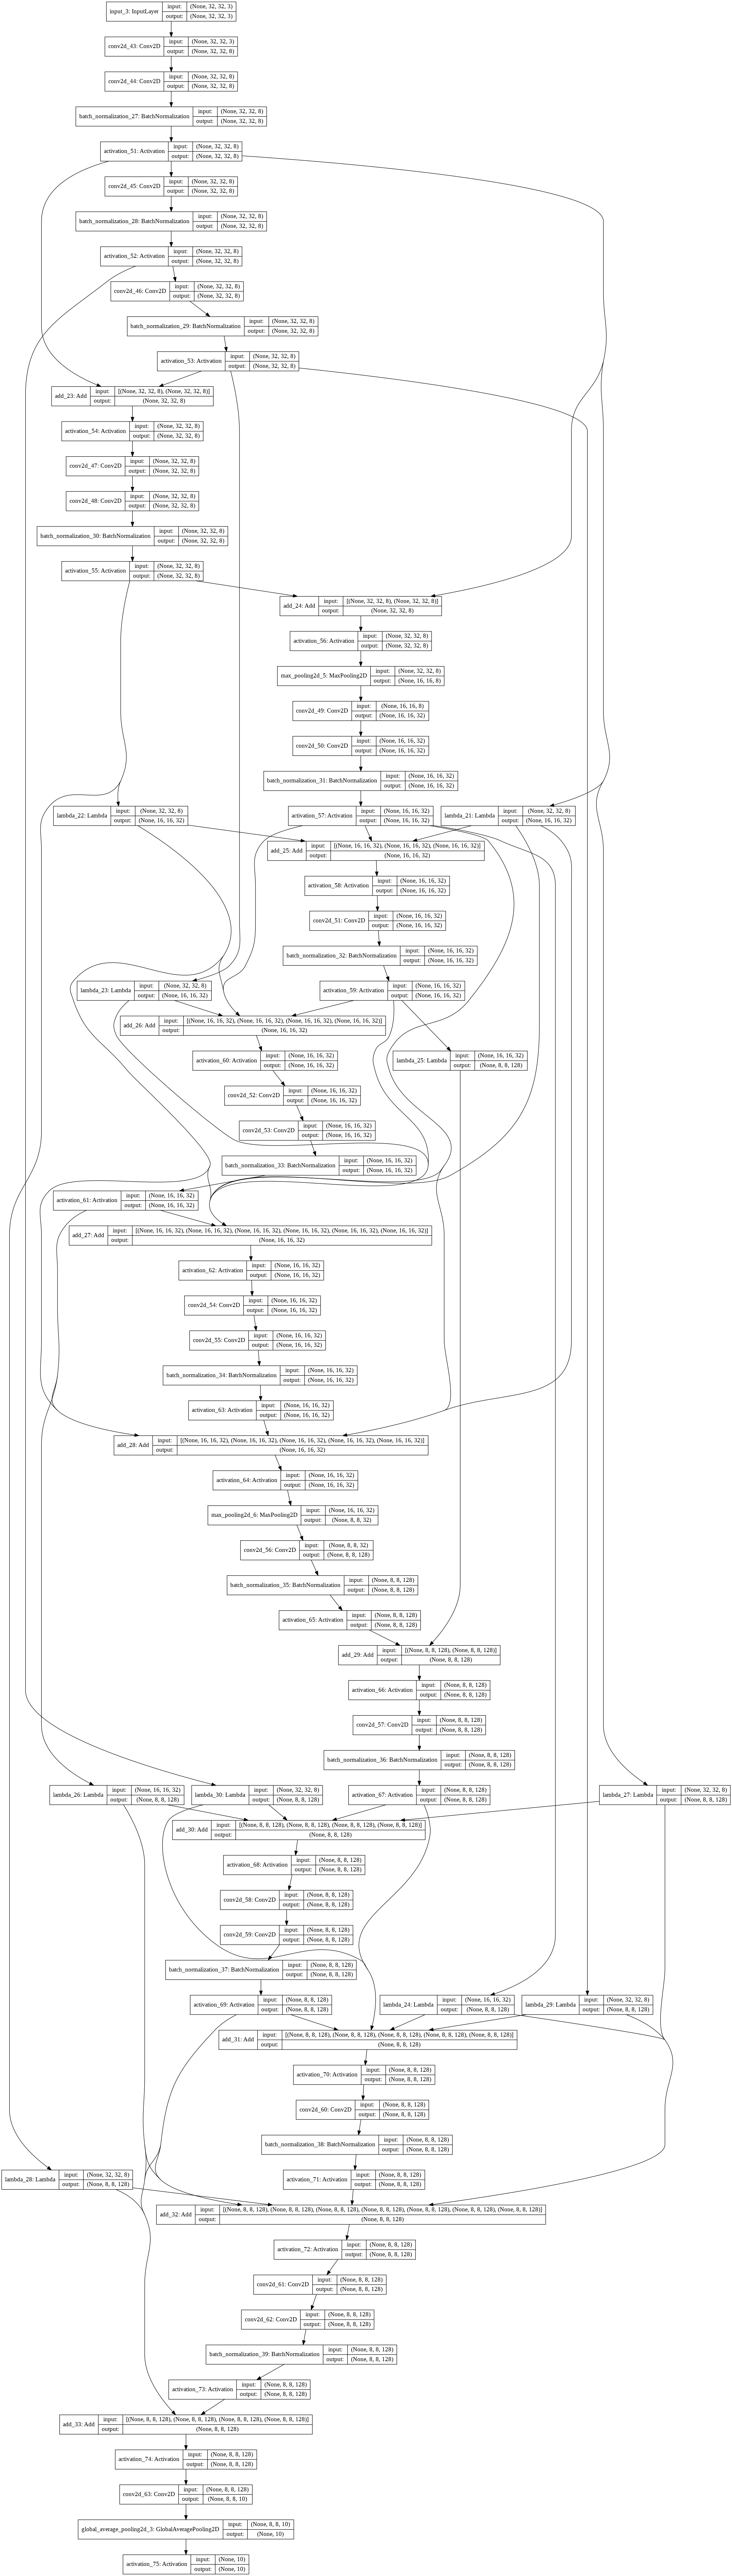

In [63]:
keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)


##Train model


*   Prepare train and test data for training model
*   Fit model for data, with 100 Epochs, added BN and relu after each layer.

*   Checkpoint is created to save best model.





In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

train_datagen = ImageDataGenerator(featurewise_center = True, 
                                   featurewise_std_normalization = True,
                                   rotation_range = 10,
                                   zoom_range = 0.10,
                                  )
test_datagen = ImageDataGenerator(featurewise_center = True, featurewise_std_normalization = True)
train_datagen.fit(train_features)
test_datagen.fit(test_features)

train_data_iter = train_datagen.flow(train_features,train_labels, batch_size = 128)
test_data_iter =  test_datagen.flow(test_features,test_labels, batch_size = 10000)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

CKPT = ModelCheckpoint(filepath = "drive/My Drive/newbest_model_enas.hdf5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max', period=1)


In [65]:

model_info = model.fit_generator(train_data_iter,
                                 steps_per_epoch = 300, nb_epoch = 30, 
                                 validation_data = test_data_iter.next(), verbose=1, callbacks = [CKPT])
model.save('drive/My Drive/newbest_model_enas.h5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=300, validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., epochs=30)`
  after removing the cwd from sys.path.




Epoch 1/30
300/300 [==============================] - 775s 3s/step - loss: 1.5046 - acc: 0.4537 - val_loss: 3.2401 - val_acc: 0.2377

Epoch 00001: val_acc improved from -inf to 0.23770, saving model to drive/My Drive/newbest_model_enas.hdf5
Epoch 2/30
300/300 [==============================] - 771s 3s/step - loss: 1.1477 - acc: 0.5842 - val_loss: 1.6344 - val_acc: 0.4796

Epoch 00002: val_acc improved from 0.23770 to 0.47960, saving model to drive/My Drive/newbest_model_enas.hdf5
Epoch 3/30
300/300 [==============================] - 775s 3s/step - loss: 0.9745 - acc: 0.6541 - val_loss: 1.5164 - val_acc: 0.5072

Epoch 00003: val_acc improved from 0.47960 to 0.50720, saving model to drive/My Drive/newbest_model_enas.hdf5
Epoch 4/30
300/300 [==============================] - 771s 3s/step - loss: 0.8822 - acc: 0.6860 - val_loss: 1.6535 - val_acc: 0.5057

Epoch 00004: val_acc did not improve from 0.50720
Epoch 5/30
300/300 [==============================] - 768s 3s/step - loss: 0.7980 - a

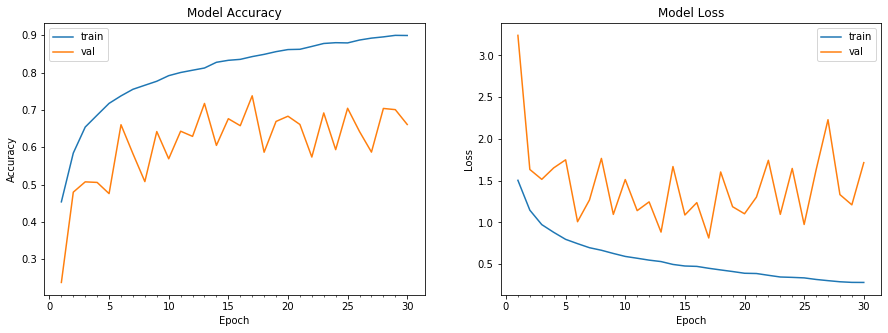

In [66]:
plot_model_history(model_info)  

In [67]:
model.load_weights("drive/My Drive/newbest_model_enas.hdf5")
test_features, test_labels = test_data_iter.next()
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

Accuracy on test data is: 73.78
